In [11]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
from PIL import Image, ImageDraw
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch

processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny")
model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny")

In [17]:
image = Image.open("data/football-match.jpg")
tensor_image = ToTensor()(image)
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
print(outputs.keys())

odict_keys(['logits', 'pred_boxes', 'last_hidden_state'])


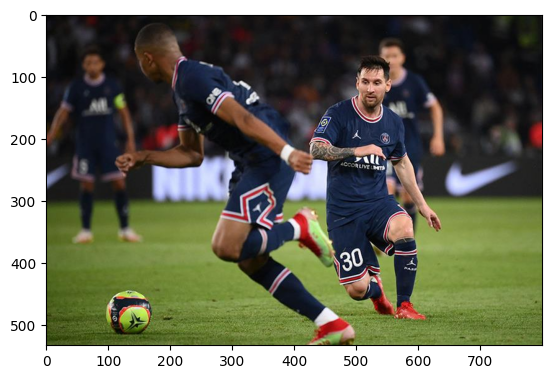

In [18]:
plt.imshow(image)

In [5]:
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected person with confidence 0.996 at location [422.34, 65.2, 643.71, 495.43]
Detected sports ball with confidence 1.0 at location [94.06, 445.82, 175.38, 517.45]
Detected person with confidence 0.989 at location [117.29, 17.39, 504.83, 527.9]
Detected person with confidence 0.999 at location [0.4, 57.93, 150.95, 372.67]
Detected person with confidence 0.987 at location [540.53, 39.56, 645.06, 303.69]


In [6]:
results

{'scores': tensor([0.9964, 0.9998, 0.9886, 0.9993, 0.9872], grad_fn=<IndexBackward0>),
 'labels': tensor([ 1, 37,  1,  1,  1]),
 'boxes': tensor([[4.2234e+02, 6.5199e+01, 6.4371e+02, 4.9543e+02],
         [9.4063e+01, 4.4582e+02, 1.7538e+02, 5.1745e+02],
         [1.1729e+02, 1.7386e+01, 5.0483e+02, 5.2790e+02],
         [4.0025e-01, 5.7934e+01, 1.5095e+02, 3.7267e+02],
         [5.4053e+02, 3.9562e+01, 6.4506e+02, 3.0369e+02]],
        grad_fn=<IndexBackward0>)}

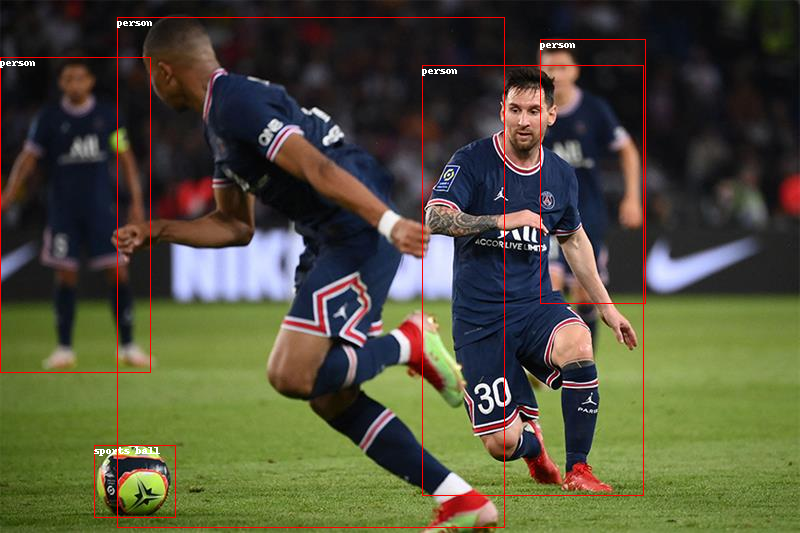

In [20]:
draw = ImageDraw.Draw(image, "RGBA")

for label, box in zip(results["labels"], results["boxes"]):
  x_0, y_0, x_1, y_1 = tuple(box)
  draw.rectangle((x_0, y_0, x_1, y_1), outline='red', width=1)
  draw.text((x_0, y_0), model.config.id2label[label.item()], fill='white')

image